In [1]:
import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output
from utils import *
import gym
import time
import pandas
import numpy as np
import ipdb
import pickle
from tqdm import tqdm
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from brain.A2C import *
%matplotlib inline

In [2]:
env = gym.make('CartPole-v0')
env.seed(1)

[1]

In [3]:
# Superparameters
MAX_EPISODE = 1000
MAX_EP_STEPS = 200   # maximum time step in one episode
RENDER = False  # rendering wastes time
GAMMA = 0.9     # reward discount in TD error
LR_A = 0.001    # learning rate for actor
LR_C = 0.005     # learning rate for critic

N_F = env.observation_space.shape[0]
N_A = env.action_space.n

In [4]:
actor = Actor(sess, n_features=N_F, n_actions=N_A, lr=LR_A)
critic = Critic(sess, n_features=N_F, lr=LR_C)    
sess.run(tf.global_variables_initializer())
# we need a good teacher, so the teacher should learn faster than the actor

In [5]:
def try_one_episode(max_episode=200):
    observation = env.reset()
    for i in range(max_episode):
        env.render(mode='rgb_array')
        # observation = discretize(observation)
        show_state(env, i, None)
        action = actor.choose_action(observation)
        observation, reward, done, info = env.step(action)
        if done:
            break
    clear_output(wait=True)

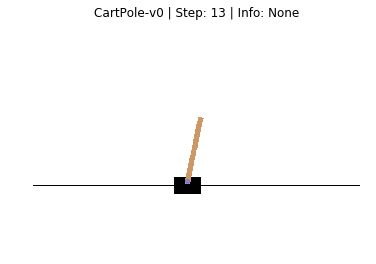

In [6]:
try_one_episode(max_episode=200)

In [7]:
final_rewards = []
for i_episode in tqdm(range(MAX_EPISODE)):
    s = env.reset()
    t = 0
    track_r = []
    while True:
        a = actor.choose_action(s)

        s_, r, done, info = env.step(a)

        track_r.append(r)
        if done: 
            r = -20

        td_error = critic.learn(s, r, s_)  # gradient = grad[r + gamma * V(s_) - V(s)]
        actor.learn(s, a, td_error)     # true_gradient = grad[logPi(s,a) * td_error]

        s = s_
        t += 1

        if done or t >= MAX_EP_STEPS:
            break
    final_rewards.append(np.sum(track_r))

100%|██████████| 1000/1000 [12:05<00:00,  1.38it/s]


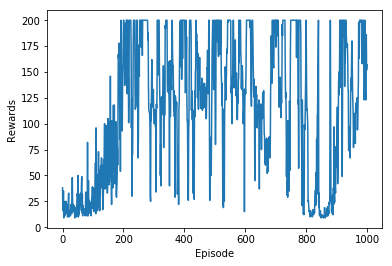

In [8]:
x = np.arange(len(final_rewards))
plt.plot(x, final_rewards)
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.savefig('./image/A2C-cartpole.png')

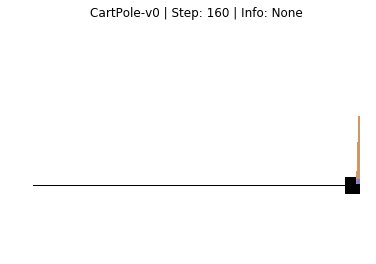

In [9]:
try_one_episode(max_episode=1000)    # 1000 for mauntaincar